Let us try out our version of the Neural Style Transfer process. The implementaion used herein got inspired by this [article](https://towardsdatascience.com/how-to-get-beautiful-results-with-neural-style-transfer-75d0c05d6489) and [tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

<a target="_blank" href="https://colab.research.google.com/github/DavidBrandes/notebooks/blob/master/style_transfer_and_feature_visualization/style_transfer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

To start everything off we first install our custom deep learning library and download the images which we will be using.

In [1]:
# Download and install the custom libary and install it
!pip install git+https://github.com/DavidBrandes/deep_learning.git
# Downlaod some images
!wget https://res.cloudinary.com/tne/image/authenticated/s--g8eRMshI--/q_80/artworks/PIETER-BRUEGEL-D-AE_DAS-SCHLARAFFENLAND_CC-BY-SA_BSTGS_8940.jpg -O /content/content.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/1/16/Henri_Rousseau_005.jpg -O /content/style.jpg

  Cloning https://github.com/DavidBrandes/deep_learning.git to /tmp/pip-req-build-fqyep9_x
  Running command git clone --filter=blob:none --quiet https://github.com/DavidBrandes/deep_learning.git /tmp/pip-req-build-fqyep9_x
  Resolved https://github.com/DavidBrandes/deep_learning.git to commit 287fa628a4e5e0ff9f52cdc20af9dd200fa14192
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for dl: filename=dl-0.1.0-py3-none-any.whl size=9354 sha256=8e6f81c3b02cd5f27a1ae6fbf4d119902002062bd741446b5e365d7c3a0dda46
  Stored in directory: /tmp/pip-ephem-wheel-cache-acpt24s9/wheels/af/63/95/078ce70c7a668301bba9c5b965d49285b19749e308aea35241
Successfully built dl
--2023-08-31 20:27:37--  https://res.cloudinary.com/tne/image/authenticated/s--g8eRMshI--/q_80/artworks/PIETER-BRUEGEL-D-AE_DAS-SCHLARAFFENLAND_CC-BY-SA_BSTGS_8940.jpg
Resolving res.cloudinary.com (res.cloudinary.com)... 151.101.1.137, 151.101.65.137, 1

In [2]:
from torch.optim import Adam
import torch

from dl.utils import image as image_utils
from dl.model.convolutional.pretrained import get_vgg19_model
from dl.model.input.input import StyleModule, ContentModule, InputModel
from dl.transform.image import RandomTransformation
from dl.parameter.image import FourierParameterization
from dl.optimization.input import InputOptimizer

As input for our model we downloaded two images, *Het Luilekkerland - The Land of Cockaigne* by *Pieter Bruegel the Elder* and *Le Rêve - The Dream* by *Henri Rousseau*. Our aim will be to transfer the style of the latter onto the former image, which should retain thereby more or less its content.

The model requires the two images to have the exact same shape. Therefore we first crop them to have the same aspect ratio and then resize them into the desired format. Let us have a look at two images.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image Shape: (693, 1024)


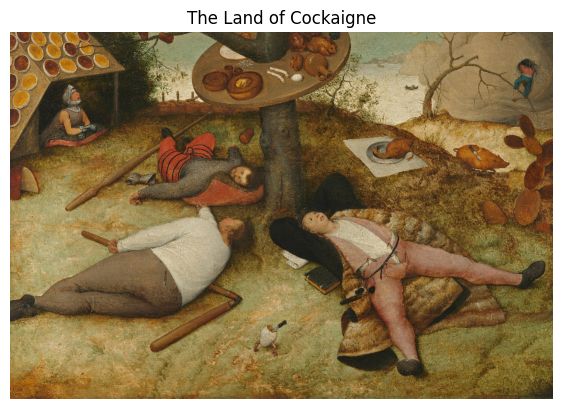

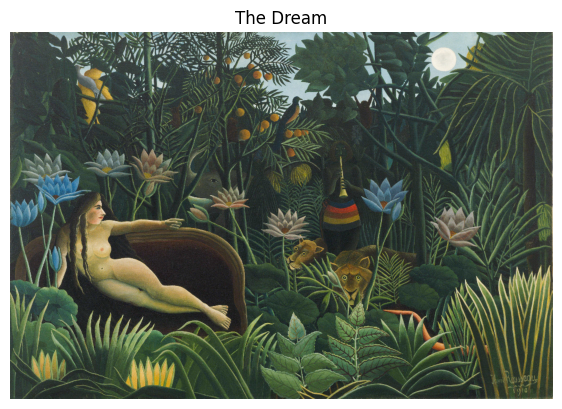

In [3]:
# How big should the longer side of the input images be
max_shape = 1024

style_img_path = "/content/style.jpg"
content_img_path = "/content/content.jpg"

style_img = image_utils.load_image(style_img_path)
content_img = image_utils.load_image(content_img_path)

# Here we crop the two images into the same format, while retaining as much of
# their content
(style_img, content_img), shape = image_utils.max_image_crops([style_img, content_img], max_size=max_shape)

print(f"Image Shape: {shape}")
image_utils.show_image(content_img, title="The Land of Cockaigne")
image_utils.show_image(style_img, title="The Dream")

In the next step we now create the model which will be processing the content, style and input image. As with the original implementation we will be using the *VGG19* model where at different layers we extract the outputs which then will be used in the optimization process.

Modules with their selected layers are then given to our custom *Input Optimzation Model* together with the base *VGG19* model. The modules are specified in the format module class, name of the base model layer to which this module should get appended to, a target which this module then tries to imitate (optional), the weight of this module in the whole optimization process (optional) and a slice of this layer which we want to use (if e.g. we only want to consider one of the base models channels or nerurons; optional).

Getting the base *VGG19* model with some slight modifications (following the original paper) is hidden away inside the *get_vgg19_model* method.

In [4]:
# Module Type, append layer of the base model, a target that should get imitated,
# the Module's weight in the optimization process, and optionally a slice of the
# selected layer which should be targeted
modules = [(ContentModule, 'relu4_2', content_img, 1, None),
           (StyleModule, 'relu1_1', style_img, 75, None),
           (StyleModule, 'relu2_1', style_img, 75, None),
           (StyleModule, 'relu3_1', style_img, 75, None),
           (StyleModule, 'relu4_1', style_img, 75, None),
           (StyleModule, 'relu5_1', style_img, 75, None),]

vgg19 = get_vgg19_model()
model = InputModel(vgg19, modules)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 230MB/s]


Added StyleModule module to layer relu1_1
Added StyleModule module to layer relu2_1
Added StyleModule module to layer relu3_1
Added StyleModule module to layer relu4_1
Added ContentModule module to layer relu4_2
Added StyleModule module to layer relu5_1


Now we are finally ready to run the optimization. As initial input we will be using some random noise, however any of the two other images might be used as well.

In order to improve the results we randomly translate the input image before each optimization step and parameterize it within a decorelated Fourier space intead of the original pixel space. See this [article](https://distill.pub/2018/differentiable-parameterizations/) for a more detailed explanation.

In [5]:
epochs = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam
optimizer_kwargs = {"lr": 0.05}

inputOpt = InputOptimizer(model, optimizer, optimizer_kwargs=optimizer_kwargs,
                          parameterization=FourierParameterization(),
                          transformation=RandomTransformation(),
                          epochs=epochs, device=device, leave=True)
# Set leave=False in order to see the individual epochs losses

input_img = image_utils.random_image(shape)
output_img = inputOpt(input_img)

Optimizing
Final Loss 2.1467e-01


It worked! *Rousseau's* style has made it into the *The Land of Cockaigne*. (The bigger clusters of a single color which appear in the style transfered image seem to be a general side effect of parameterizing the input within the Fourier space)




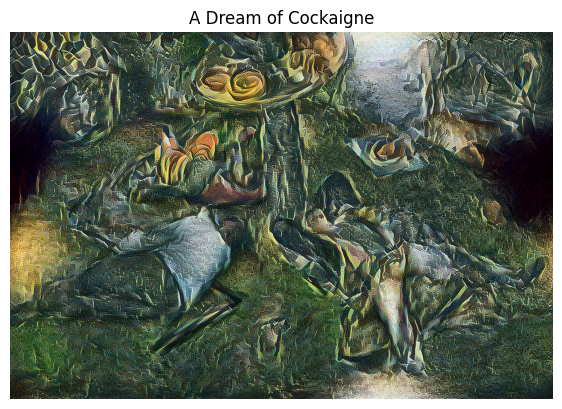

In [6]:
image_utils.show_image(output_img, title="A Dream of Cockaigne")